# Generate figures for the paper

We use this notebook to generate all figures for the paper. 

In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from matchms.filtering import (
    normalize_intensities,
    reduce_to_number_of_peaks,
    require_minimum_number_of_peaks,
    select_by_mz,
    select_by_relative_intensity,
)
from matchms.importing import load_from_mgf
from matchms.similarity import CosineGreedy, ModifiedCosine
from numba import cuda
from sklearn.linear_model import LinearRegression
from simms.similarity import CudaCosineGreedy, CudaModifiedCosine
from simms.utils import Timer, download, get_correct_scores


np.random.seed(42)

plotting_style = {
    "figure.facecolor": "white",
    "text.color": ".15",
    "axes.labelcolor": ".15",
    "legend.frameon": False,
    "legend.numpoints": 1,
    "legend.scatterpoints": 1,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.color": ".15",
    "ytick.color": ".15",
    "axes.axisbelow": True,
    "image.cmap": "Greys",
    "font.family": "sans-serif",
    "font.sans-serif": [
        "Arial",
        "Liberation Sans",
        "DejaVu Sans",
        "Bitstream Vera Sans",
        "sans-serif",
    ],
    "grid.linestyle": "-",
    "lines.solid_capstyle": "round",
    "axes.grid": True,
    "axes.facecolor": "white",
    "axes.edgecolor": ".8",
    "axes.linewidth": 1,
    "grid.color": ".8",
    "xtick.major.size": 0,
    "ytick.major.size": 0,
    "xtick.minor.size": 0,
    "ytick.minor.size": 0,
    "figure.figsize": (4.9, 3.5),
    "font.size": 13.0,
    "axes.titlesize": "medium",
    "figure.titlesize": "medium",
}

# plt.style.use(plotting_style)
assert cuda.is_available()

We define the limits for variables under investigation for the plots.

In [3]:
# We compare pairwise similarity performance on `spectra_file`
# We can use pickled version for much faster loading times
SPECTRA_FILE = "GNPS-random-10k.mgf"

# spectra_file = "MASSBANK.mgf"  # Smaller set for faster runs

# How many spectra to sample for reference and query, this is quite small for a GPU, but we use
# it to keep MatchMS similarity fast, to obtain "correct" scores for equivalence compairson
N_SPECTRA = 512 * 4

# limits for testing tolerance influence on performance
MIN_TOLERANCE = 1e-6
MAX_TOLERANCE = 1000.0

# limits for testing match_limit influence on performance
MIN_MATCH_LIMIT = 8
MAX_MATCH_LIMIT = 2048 * 2

# limits for testing num peaks influence on performance
MIN_NUM_PEAKS = 32
MAX_NUM_PEAKS = 2048

# Max evals
NUM_EVALS = 16

# Default params
N_MAX_PEAKS = 1024

# Hardware matters! These results are only repeatable using this GPU (shown as an output)
! nvidia-smi -L
! echo Number of CPU cores $(nproc)

GPU 0: NVIDIA GeForce RTX 2070 with Max-Q Design (UUID: GPU-f6e241c8-f0ad-720e-be22-2713a6b0868d)
Number of CPU cores 12


In [4]:
spectra = list(load_from_mgf(str(download(SPECTRA_FILE))))
spectra[:5]

[Spectrum(precursor m/z=827.32, 10 fragments between 79.1 and 137.1),
 Spectrum(precursor m/z=555.42, 75 fragments between 51.9 and 555.4),
 Spectrum(precursor m/z=520.36, 88 fragments between 47.1 and 522.4),
 Spectrum(precursor m/z=890.48, 1 fragments between 302.1 and 302.1),
 Spectrum(precursor m/z=385.16, 49 fragments between 50.1 and 386.2)]

# Accuracy with minimal filters

In [5]:
np.random.seed(42)

references = np.random.choice(
    spectra,
    size=N_SPECTRA,
)

queries = np.random.choice(
    spectra,
    size=N_SPECTRA,
)


def process_spectrum(spectrum):
    """
    Suggested way to filter the given spectra.
    """
    spectrum = select_by_mz(spectrum, mz_to=1000.0)
    spectrum = normalize_intensities(spectrum)
    spectrum = select_by_relative_intensity(spectrum, intensity_from=0.001)
    spectrum = reduce_to_number_of_peaks(spectrum, n_max=N_MAX_PEAKS)
    spectrum = require_minimum_number_of_peaks(spectrum, n_required=1)
    return spectrum


references = list(process_spectrum(s) for s in references)
references = list(r for r in references if r is not None)

queries = list(process_spectrum(s) for s in queries)
queries = list(r for r in queries if r is not None)

smallest_reference = min(len(sp.peaks) for sp in references)
smallest_query = min(len(sp.peaks) for sp in queries)

print(f"Smallest reference: {smallest_reference} peaks")
print(f"Smallest query: {smallest_query} peaks")
print(
    f"Number of comaprisons {len(references)} * {len(queries)} = {len(references) * len(queries)}"
)
references[:5], queries[:5]

Smallest reference: 1 peaks
Smallest query: 1 peaks
Number of comaprisons 2038 * 2036 = 4149368


([Spectrum(precursor m/z=306.21, 26 fragments between 58.0 and 326.2),
  Spectrum(precursor m/z=195.09, 60 fragments between 50.6 and 201.5),
  Spectrum(precursor m/z=261.03, 11 fragments between 94.0 and 199.0),
  Spectrum(precursor m/z=872.77, 27 fragments between 91.9 and 841.8),
  Spectrum(precursor m/z=753.23, 1 fragments between 753.2 and 753.2)],
 [Spectrum(precursor m/z=233.66, 178 fragments between 55.1 and 379.8),
  Spectrum(precursor m/z=433.33, 142 fragments between 79.1 and 465.3),
  Spectrum(precursor m/z=277.05, 11 fragments between 77.0 and 277.0),
  Spectrum(precursor m/z=321.07, 18 fragments between 98.1 and 321.2),
  Spectrum(precursor m/z=229.03, 6 fragments between 228.1 and 257.2)])

### Greedy Cosine

In [6]:
batch_size = max(len(references), len(queries))

# Default arguments match in both...
scores = get_correct_scores(
    references=references, queries=queries, similarity_class=CosineGreedy
)

In [7]:
scores_cu = CudaCosineGreedy(
    n_max_peaks=N_MAX_PEAKS,
    batch_size=batch_size,
).matrix(references, queries)

### Modified Cosine

In [8]:
batch_size = max(len(references), len(queries))

scores_modified = get_correct_scores(
    references=references, queries=queries, similarity_class=ModifiedCosine
)

In [9]:
# from simms.similarity import CudaModifiedCosine
scores_cu_modified = CudaModifiedCosine(
    n_max_peaks=N_MAX_PEAKS, batch_size=batch_size
).matrix(references, queries)

### Direct comparison

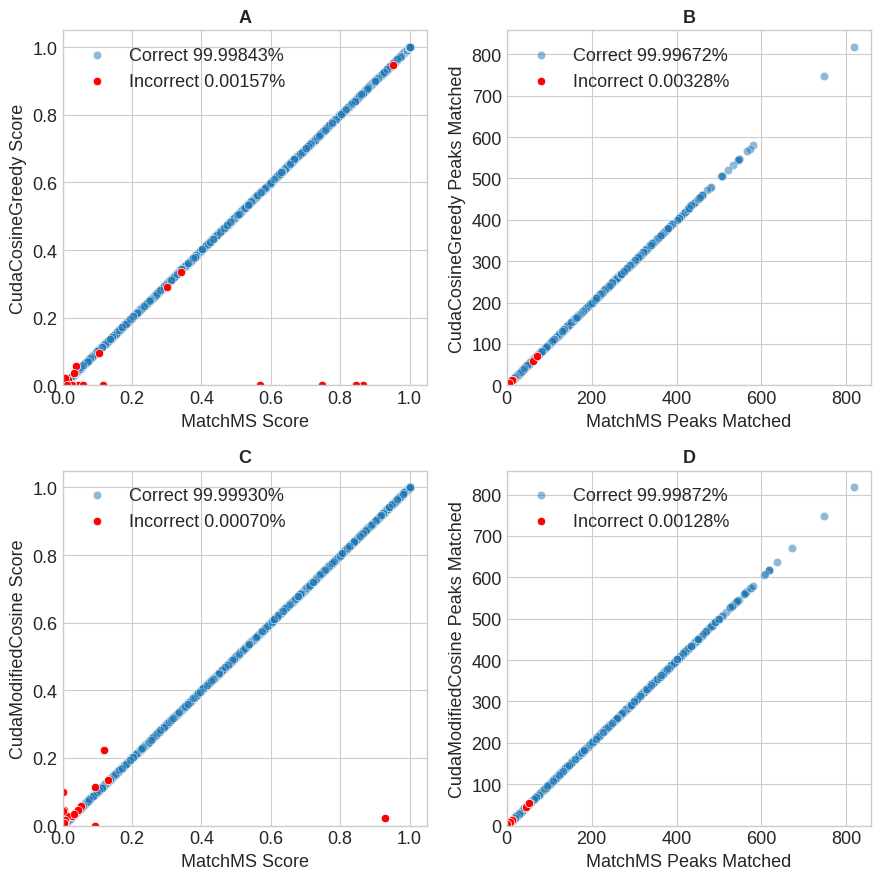

In [13]:
# Takes a good minute or two
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
labels = ["A", "B", "C", "D"]
plots_data = [
    (
        scores,
        scores_cu,
        "MatchMS Score",
        "CudaCosineGreedy Score",
        "MatchMS Peaks Matched",
        "CudaCosineGreedy Peaks Matched",
    ),
    (
        scores_modified,
        scores_cu_modified,
        "MatchMS Score",
        "CudaModifiedCosine Score",
        "MatchMS Peaks Matched",
        "CudaModifiedCosine Peaks Matched",
    ),
]

for i, (
    score,
    score_cu,
    xlabel_score,
    ylabel_score,
    xlabel_matches,
    ylabel_matches,
) in enumerate(plots_data):
    row, col = divmod(i * 2, 2)

    # Scores Plot
    ax = axs[row, col]
    simms_scores = score_cu["score"].ravel()
    matchms_scores = score["score"].ravel()
    is_overflow = score_cu["overflow"].ravel() == 1

    is_correct = np.isclose(simms_scores, matchms_scores, atol=0.001)
    is_wrong = ~is_correct
    is_wrong_without_warning = is_wrong & ~is_overflow
    is_wrong_with_warning = is_wrong & is_overflow

    sns.scatterplot(
        x=simms_scores[is_correct],
        y=matchms_scores[is_correct],
        alpha=0.5,
        label=f"Correct {is_correct.mean()*100:.5f}%",
        ax=ax,
    )
    sns.scatterplot(
        x=matchms_scores[is_wrong_with_warning],
        y=simms_scores[is_wrong_with_warning],
        color="orange",
        label=f"Overflow {is_wrong_with_warning.mean()*100:.5f}%",
        ax=ax,
    )
    sns.scatterplot(
        x=matchms_scores[is_wrong_without_warning],
        y=simms_scores[is_wrong_without_warning],
        color="red",
        label=f"Incorrect {(is_wrong_without_warning).mean()*100:.5f}%",
        ax=ax,
    )

    ax.legend(loc="upper left")
    ax.set_xlabel(xlabel_score)
    ax.set_ylabel(ylabel_score)
    ax.set_ylim([0, None])
    ax.set_xlim([0, None])
    ax.set_title(labels[i * 2], fontweight="bold")

    # Matches Plot
    ax = axs[row, col + 1]
    simms_matches = score_cu["matches"].ravel()
    matchms_matches = score["matches"].ravel()
    is_overflow = score_cu["overflow"].ravel() == 1

    is_correct = np.isclose(simms_matches, matchms_matches, atol=0.001)
    is_wrong = ~is_correct
    is_wrong_without_warning = is_wrong & ~is_overflow
    is_wrong_with_warning = is_wrong & is_overflow

    sns.scatterplot(
        x=matchms_matches[is_correct],
        y=simms_matches[is_correct],
        alpha=0.5,
        label=f"Correct {is_correct.mean()*100:.5f}%",
        ax=ax,
    )
    sns.scatterplot(
        x=matchms_matches[is_wrong_with_warning],
        y=simms_matches[is_wrong_with_warning],
        color="orange",
        label=f"Overflow {is_wrong_with_warning.mean()*100:.5f}%",
        ax=ax,
    )
    sns.scatterplot(
        x=matchms_matches[is_wrong_without_warning],
        y=simms_matches[is_wrong_without_warning],
        color="red",
        label=f"Incorrect {(is_wrong_without_warning).mean()*100:.5f}%",
        ax=ax,
    )

    ax.legend(loc="upper left")
    ax.set_xlabel(xlabel_matches)
    ax.set_ylabel(ylabel_matches)
    ax.set_ylim([0, None])
    ax.set_xlim([0, None])
    ax.set_title(labels[i * 2 + 1], fontweight="bold")

plt.tight_layout()
plt.savefig("direct_acc.png")
plt.show()

# Greedy Cosine Performance

## Tolerance

In [11]:
np.random.seed(123)

references = np.random.choice(
    spectra,
    size=256,
    replace=False,
)

queries = np.random.choice(
    spectra,
    size=256,
    replace=False,
)
batch_size = max(len(references), len(queries))

tolerances = np.logspace(
    np.log10(MIN_TOLERANCE), np.log10(MAX_TOLERANCE), endpoint=True, num=NUM_EVALS
)

jobs = []
for variable in tolerances:

    def loop(tolerance):
        tolerance = float(tolerance)
        scores = get_correct_scores(
            references=references,
            queries=queries,
            similarity_class=CosineGreedy,
            tolerance=tolerance,
        )
        kernel = CudaCosineGreedy(
            tolerance=tolerance,
            batch_size=batch_size,
        )
        kernel.matrix(references[:4], queries[:4])
        with Timer() as t:
            scores_cu = kernel.matrix(references, queries)
        return scores, scores_cu, t.duration

    jobs.append(delayed(loop)(variable))
tolerance_perf_data = Parallel(1)(jobs)

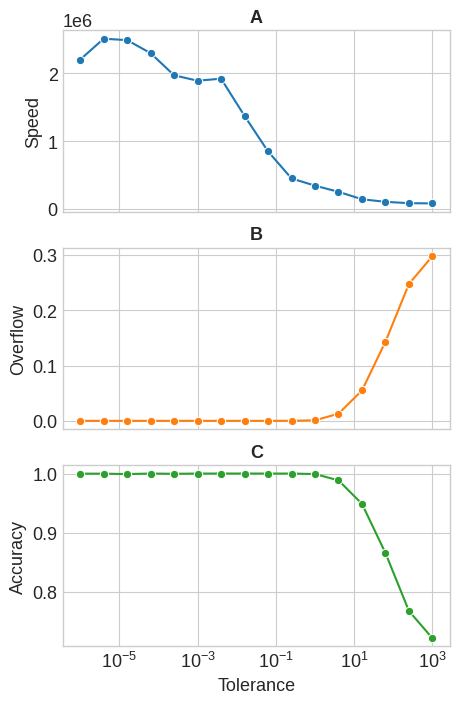

In [12]:
##### We use largest batch size for best error estimates


def plot_tol_and_perf(
    axis: list[plt.Axes] = None,
    data=None,
    tolerances=tolerances,
):
    ov_means = []
    match_means = []
    iseq_means = []
    spectra_per_second = []
    for scores, scores_cu, time_per_batch in data:
        a = scores["score"].ravel()
        am = scores["matches"].ravel()
        ov = scores_cu["overflow"].ravel() == 1
        b = scores_cu["score"].ravel()
        bm = scores_cu["matches"].ravel()
        iseq = np.isclose(a, b, atol=0.001)

        ov_means.append(ov.mean())
        iseq_means.append(iseq.mean())
        match_means.append(bm.mean())
        pairs = len(references) * len(queries)
        spectra_per_second.append(pairs / time_per_batch)

    spectra_per_second = np.array(spectra_per_second)
    prop_cycle = plt.rcParams["axes.prop_cycle"]
    colors = list(prop_cycle.by_key()["color"])

    ax = axis[0]
    sns.lineplot(x=tolerances, y=spectra_per_second, marker="o", color=colors[0], ax=ax)
    ax.set_ylabel("Speed")
    ax.set_xscale("log")
    ax.set_title("A", fontweight="bold")

    ax = axis[1]
    sns.lineplot(x=tolerances, y=ov_means, marker="o", color=colors[1], ax=ax)

    ax.set_ylabel("Overflow")
    ax.set_xscale("log")
    ax.set_title("B", fontweight="bold")

    ax = axis[2]
    sns.lineplot(x=tolerances, y=iseq_means, marker="o", color=colors[2], ax=ax)

    ax.set_ylabel("Accuracy")
    ax.set_xscale("log")
    ax.set_xlabel("Tolerance")
    ax.set_title("C", fontweight="bold")


fig, axd = plt.subplot_mosaic([["a"], ["b"], ["c"]], figsize=(5, 8), sharex=True)

plot_tol_and_perf(axis=[axd[k] for k in "a b c".split()], data=tolerance_perf_data)

## Match Limit

In [13]:
np.random.seed(111)

match_limits = np.logspace(
    np.log10(MIN_MATCH_LIMIT), np.log10(MAX_MATCH_LIMIT), endpoint=True, num=NUM_EVALS
)

references = np.random.choice(
    spectra,
    size=256,
    replace=False,
)

queries = np.random.choice(
    spectra,
    size=256,
    replace=False,
)
batch_size = max(len(references), len(queries))
scores = get_correct_scores(
    references=references, queries=queries, similarity_class=CosineGreedy, tolerance=0.1
)

In [14]:
jobs = []
for variable in match_limits:

    def loop(match_limit):
        match_limit = int(match_limit)
        kernel = CudaCosineGreedy(match_limit=match_limit, batch_size=batch_size)
        kernel.matrix(references[:4], queries[:4])
        with Timer() as t:
            scores_cu = kernel.matrix(references, queries)
        return scores, scores_cu, t.duration

    jobs.append(delayed(loop)(variable))
match_limit_data = Parallel(1)(jobs)

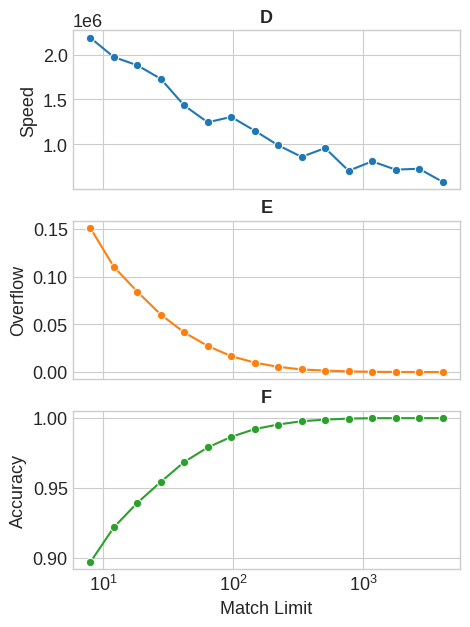

In [15]:
def plot_ml_and_perf(axis: list[plt.Axes] = None, match_limits=match_limits, data=None):
    ov_means = []
    match_means = []
    iseq_means = []
    pairs_per_second = []
    for scores, scores_cu, duration in data:
        a = scores["score"].ravel()
        am = scores["matches"].ravel()
        ov = scores_cu["overflow"].ravel() == 1
        b = scores_cu["score"].ravel()
        bm = scores_cu["matches"].ravel()
        iseq = np.isclose(a, b, atol=0.001)

        ov_means.append(ov.mean())
        iseq_means.append(iseq.mean())
        match_means.append(bm.mean())
        pairs_per_second.append((len(references) * len(queries)) / duration)

    pairs_per_second = np.array(pairs_per_second)

    prop_cycle = plt.rcParams["axes.prop_cycle"]
    colors = iter(list(prop_cycle.by_key()["color"]))

    ax = axis[0]
    sns.lineplot(
        x=match_limits, y=pairs_per_second, color=next(colors), marker="o", ax=ax
    )
    ax.set_ylabel("Speed")
    ax.set_title("D", fontweight="bold")

    ax = axis[1]
    sns.lineplot(x=match_limits, y=ov_means, color=next(colors), marker="o", ax=ax)
    ax.set_ylabel("Overflow")
    ax.set_title("E", fontweight="bold")

    ax = axis[2]
    sns.lineplot(x=match_limits, y=iseq_means, marker="o", color=next(colors), ax=ax)
    ax.set_ylabel("Accuracy")
    ax.set_xscale("log")
    ax.set_xlabel("Match Limit")
    ax.set_title("F", fontweight="bold")


fig, axd = plt.subplot_mosaic([["a"], ["b"], ["c"]], figsize=(5, 7), sharex=True)

plot_ml_and_perf(
    axis=[axd[k] for k in "a b c".split()],
    data=match_limit_data,
)

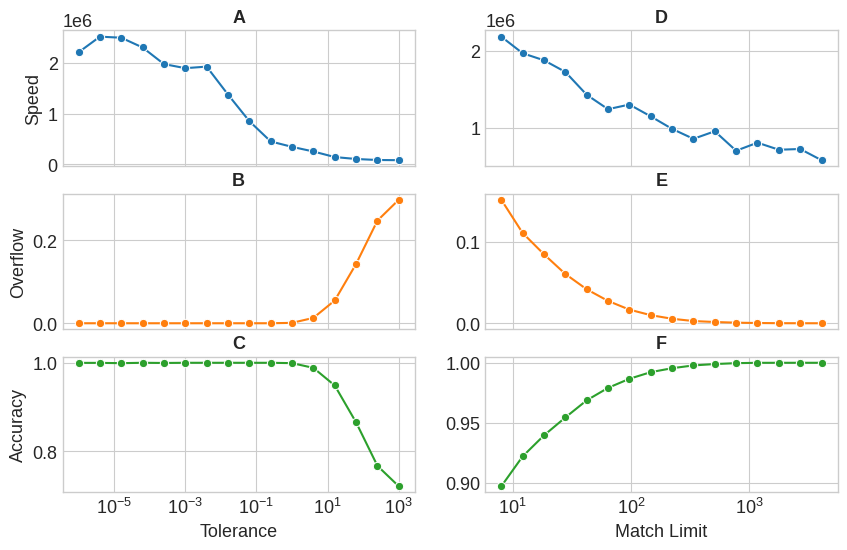

In [16]:
fig, axd = plt.subplot_mosaic(
    [["a", "A"], ["b", "B"], ["c", "C"]],
    figsize=(10, 6),
)

plot_tol_and_perf(axis=[axd[k] for k in "a b c".split()], data=tolerance_perf_data)

# match limit
plot_ml_and_perf(axis=[axd[k] for k in "A B C".split()], data=match_limit_data)
[axd[k].set_ylabel(None) for k in "A B C".split()]
[axd[k].set_xscale("log") for k in "A B".split()]
[axd[k].set_xticklabels([]) for k in "A B".split()]
[axd[k].set_xticklabels([]) for k in "a b".split()]
plt.savefig("plot.png")

## SimMS vs. BLINK

Compare:

1. Accuracy as a function of tolerance
1. Runtime as a function of total number of comparisonsfor

Accuracy of BLINK decreases at any fixed tolerance as `bin_width` parameter increases. Unfortunately, memory requirements increase as `1/bin_width`.

We use the maximum practical `bin_width` for the current workstation, that doesn't result in OOM.

We use the best possible setup for BLINK, `bin_width=1e-6`.

In [44]:
import blink
import torch
from tqdm.cli import tqdm


tolerances = np.logspace(
    start=-5,
    stop=-1,
    endpoint=True,
    num=8,
)

np.random.seed(123)

references = np.random.choice(
    spectra,
    size=512 * 2,
    replace=False,
)

queries = np.random.choice(
    spectra,
    size=512 * 2,
    replace=False,
)
batch_size = max(len(references), len(queries))
n_reps = 10  # Repeat each kernel 10 times and average to get better estimate of speed performance


def measure_blink_vs_simms():
    data = []
    for tolerance in tqdm(tolerances):
        tolerance = float(tolerance)

        ## MatchMS
        # scores = get_correct_scores(
        #     references=references,
        #     queries=queries,
        #     similarity_class=CosineGreedy,
        #     tolerance=tolerance,
        # )

        ## SimMS
        kernel = CudaCosineGreedy(
            tolerance=tolerance,
            batch_size=batch_size,
        )
        kernel.matrix(references[:4], queries[:4])
        with Timer() as t_simms:
            for _ in range(n_reps):
                scores_cu = kernel.matrix(references, queries)

        scores = scores_cu  # TODO

        acc = np.isclose(
            scores["score"].ravel(), scores_cu["score"].ravel(), atol=0.001
        ).mean()
        data.append(
            dict(
                method="simms",
                tolerance=tolerance,
                time=t_simms.duration / n_reps,
                acc=acc,
                speed=float(
                    len(references) * len(queries) / (t_simms.duration / n_reps)
                ),
            )
        )

        ## BLINK
        torch.cuda.empty_cache()
        queries_ = [e.peaks.to_numpy.T for e in queries]
        references_ = [e.peaks.to_numpy.T for e in references]
        query_precursor_mz_ = [e.get("precursor_mz") for e in queries]
        reference_precursor_mz_ = [e.get("precursor_mz") for e in references]
        # blink_bin_width = 0.00001
        # blink_bin_width = tolerance / 5
        blink_bin_width = min(
            tolerance, 0.001
        )  # with lower tolerance, it is necessary to use bin width <= tolerance
        # for blink_bin_width in [0.00001, 0.0001, 0.001]:
        # On the one hand, BLINK can only work with tolerances in range (bin_width, bin_width * 1000)
        # On the other, BLINK memory requirements for discretization grow as 1/bin_width.
        # This requires us to use different bin widths for different tolerances and take all configurations into account
        # if tolerance >= blink_bin_width and tolerance <= blink_bin_width * 256:
        print("SET", tolerance, blink_bin_width, 1 / blink_bin_width)
        with Timer() as t_blink:
            for _ in range(n_reps):
                blink_discretized_spectra = blink.discretize_spectra(
                    references_,
                    queries_,
                    reference_precursor_mz_,
                    query_precursor_mz_,
                    intensity_power=1.0,  # since BLINK default is 0.5
                    bin_width=blink_bin_width,
                    tolerance=tolerance,
                )
                blink_results = blink.score_sparse_spectra(
                    blink_discretized_spectra, gpu=True
                )
        acc = np.isclose(
            scores["score"].ravel(),
            blink_results["mzi"].todense().ravel(),
            atol=0.001,
        ).mean()
        data.append(
            dict(
                method="blink",
                tolerance=tolerance,
                blink_bin_width=blink_bin_width,
                time=t_blink.duration / n_reps,
                speed=float(
                    len(references) * len(queries) / (t_blink.duration / n_reps)
                ),
                acc=acc,
            )
        )
    data = pd.DataFrame(data)
    return data


perf_df = measure_blink_vs_simms()

  0%|          | 0/8 [00:00<?, ?it/s]

SET 1e-05 1e-05 99999.99999999999


/home/tornikeo/micromamba/envs/pb2/lib/python3.11/site-packages/blink/spectral_normalization.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  inorm = np.array([1.0/np.linalg.norm(mzi[1]**intensity_power) for mzi in mzis])
 12%|█▎        | 1/8 [00:08<00:56,  8.02s/it]

SET 3.727593720314938e-05 3.727593720314938e-05 26826.95795279727


/home/tornikeo/micromamba/envs/pb2/lib/python3.11/site-packages/blink/spectral_normalization.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  inorm = np.array([1.0/np.linalg.norm(mzi[1]**intensity_power) for mzi in mzis])
 25%|██▌       | 2/8 [00:13<00:40,  6.71s/it]

SET 0.00013894954943731373 0.00013894954943731373 7196.856730011522


/home/tornikeo/micromamba/envs/pb2/lib/python3.11/site-packages/blink/spectral_normalization.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  inorm = np.array([1.0/np.linalg.norm(mzi[1]**intensity_power) for mzi in mzis])
 38%|███▊      | 3/8 [00:19<00:30,  6.09s/it]

SET 0.0005179474679231213 0.0005179474679231213 1930.6977288832495


/home/tornikeo/micromamba/envs/pb2/lib/python3.11/site-packages/blink/spectral_normalization.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  inorm = np.array([1.0/np.linalg.norm(mzi[1]**intensity_power) for mzi in mzis])
 50%|█████     | 4/8 [00:23<00:21,  5.46s/it]

SET 0.0019306977288832496 0.001 1000.0


/home/tornikeo/micromamba/envs/pb2/lib/python3.11/site-packages/blink/spectral_normalization.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  inorm = np.array([1.0/np.linalg.norm(mzi[1]**intensity_power) for mzi in mzis])
 62%|██████▎   | 5/8 [00:29<00:16,  5.57s/it]

SET 0.007196856730011514 0.001 1000.0


/home/tornikeo/micromamba/envs/pb2/lib/python3.11/site-packages/blink/spectral_normalization.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  inorm = np.array([1.0/np.linalg.norm(mzi[1]**intensity_power) for mzi in mzis])
 75%|███████▌  | 6/8 [00:35<00:11,  5.87s/it]

SET 0.026826957952797246 0.001 1000.0


/home/tornikeo/micromamba/envs/pb2/lib/python3.11/site-packages/blink/spectral_normalization.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  inorm = np.array([1.0/np.linalg.norm(mzi[1]**intensity_power) for mzi in mzis])
 88%|████████▊ | 7/8 [00:45<00:07,  7.20s/it]

SET 0.1 0.001 1000.0


/home/tornikeo/micromamba/envs/pb2/lib/python3.11/site-packages/blink/spectral_normalization.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  inorm = np.array([1.0/np.linalg.norm(mzi[1]**intensity_power) for mzi in mzis])
100%|██████████| 8/8 [01:13<00:00,  9.22s/it]


# Performance plots

Requires us to run notebooks under `notebooks/figures/performance` first, to generate performance accross multiple GPU types.

/tmp/ipykernel_35409/3628115559.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/tmp/ipykernel_35409/3628115559.py:46: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


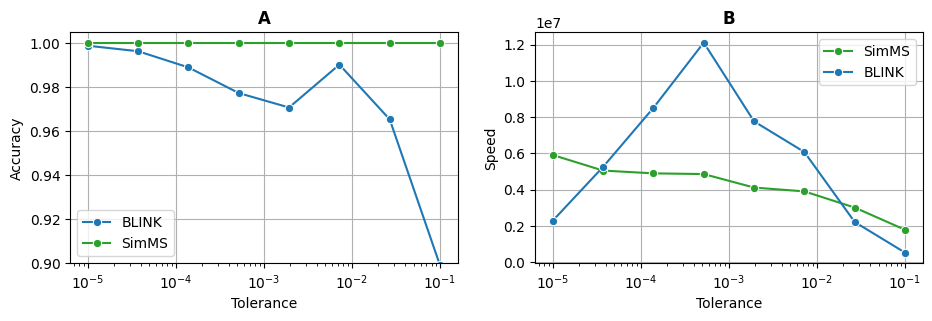

In [68]:
fig, axs = plt.subplot_mosaic(
    "ab",
    figsize=(11, 3),
    # sharex=True,
)

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = list(prop_cycle.by_key()["color"])
# perf_df["Bin Width"] = "BLINK " + perf_df.blink_bin_width.astype(str)
gp = perf_df.groupby("method")
plt.sca(axs["a"])
sns.lineplot(
    gp.get_group("blink"),
    x="tolerance",
    y="acc",
    # hue="Bin Width",
    palette="dark:r_r",
    marker="o",
    label="BLINK",
)
plt.legend()
sns.lineplot(
    gp.get_group("simms"),
    x="tolerance",
    y="acc",
    color=colors[2],
    marker="o",
    label="SimMS",
)
plt.title("A", fontweight="bold")
plt.xscale("log")
plt.ylim([0.8999, None])
plt.ylabel("Accuracy")
plt.xlabel("Tolerance")
plt.grid(True, "major")

plt.sca(axs["b"])
sns.lineplot(
    gp.get_group("simms"),
    x="tolerance",
    y="speed",
    color=colors[2],
    marker="o",
    label="SimMS",
)
sns.lineplot(
    gp.get_group("blink"),
    x="tolerance",
    y="speed",
    # hue="Bin Width",
    palette="dark:r_r",
    marker="o",
    label="BLINK",
)
# plt.legend([])
plt.title("B", fontweight="bold")
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Tolerance")
plt.ylabel("Speed")
plt.grid(True, "major")

plt.savefig("vs_blink.png", bbox_inches="tight", dpi=200)

In [70]:
perf_df

,method,tolerance,time,acc,speed,blink_bin_width
0,simms,0.000010,0.177503,1.000000,5.907363e+06,NaN
1,blink,0.000010,0.459600,0.998867,2.281496e+06,0.000010
2,simms,0.000037,0.207746,1.000000,5.047400e+06,NaN
3,blink,0.000037,0.199679,0.996355,5.251303e+06,0.000037
4,simms,0.000139,0.214266,1.000000,4.893795e+06,NaN
5,blink,0.000139,0.123235,0.989000,8.508767e+06,0.000139
6,simms,0.000518,0.215997,1.000000,4.854578e+06,NaN
7,blink,0.000518,0.086598,0.977319,1.210859e+07,0.000518
8,simms,0.001931,0.255105,1.000000,4.110371e+06,NaN
9,blink,0.001931,0.135083,0.970738,7.762450e+06,0.001000


In [6]:
import io
from pathlib import Path
import pandas as pd
from IPython.display import display


# For each notebook...
for nb in sorted(Path("notebooks/figures/performance/").glob("*.ipynb")):
    # Read the last cell's output as a JSON...
    nb_data = json.loads(nb.read_text())
    result_json = " ".join(nb_data["cells"][-1]["outputs"][0]["text"])
    res = pd.read_json(io.StringIO(result_json))
    display(res.head())

,kernel,time,pairs,label
0,CosineGreedy,3.345220,1024,MatchMS
1,ModifiedCosine,3.482526,1024,MatchMS
2,CosineGreedy,1.424222,1849,MatchMS
3,ModifiedCosine,3.620822,1849,MatchMS
4,CosineGreedy,1.503433,3364,MatchMS


,kernel,time,pairs,label
0,CudaCosineGreedy,0.116839,1024,RTX4090
1,CudaModifiedCosine,0.288408,1024,RTX4090
2,CudaCosineGreedy,0.117161,2601,RTX4090
3,CudaModifiedCosine,0.290608,2601,RTX4090
4,CudaCosineGreedy,0.123107,6400,RTX4090


,kernel,time,pairs,label
0,CudaCosineGreedy,0.073813,1024,A100PCIE
1,CudaModifiedCosine,0.152531,1024,A100PCIE
2,CudaCosineGreedy,0.074792,2601,A100PCIE
3,CudaModifiedCosine,0.159283,2601,A100PCIE
4,CudaCosineGreedy,0.085928,6400,A100PCIE


In [7]:
df = []
# For each notebook...
for nb in sorted(Path("notebooks/figures/performance/").glob("*.ipynb")):
    # Read the last cell's output as a JSON...
    nb_data = json.loads(nb.read_text())
    result_json = " ".join(nb_data["cells"][-1]["outputs"][0]["text"])
    df.append(pd.read_json(io.StringIO(result_json)))

df = pd.concat(df, axis=0)
df

,kernel,time,pairs,label
0,CosineGreedy,3.345220,1024,MatchMS
1,ModifiedCosine,3.482526,1024,MatchMS
2,CosineGreedy,1.424222,1849,MatchMS
3,ModifiedCosine,3.620822,1849,MatchMS
4,CosineGreedy,1.503433,3364,MatchMS
...,...,...,...,...
25,CudaModifiedCosine,12.249119,63568729,A100PCIE
26,CudaCosineGreedy,13.086525,159466384,A100PCIE
27,CudaModifiedCosine,31.089863,159466384,A100PCIE
28,CudaCosineGreedy,30.329247,400000000,A100PCIE


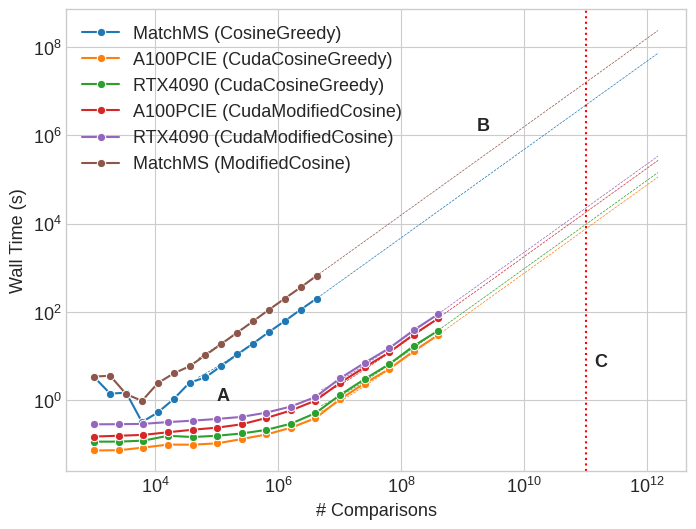

In [4]:
# Fancy formatter for time...
import io


def time_formatter(v: float, p) -> str:
    # def pluralify(s):
    #     a, b = s.split()
    #     if int(a) not in [0, 1]:
    #         s = s + "s"
    #     return s

    # if v < 60:  # Less than a minute
    # res = f"{int(v)} second"
    res = f"{v:.3e} second"
    # elif v < 3600:  # Less than an hour
    #     res = f"{int(v / 60)} minute"
    # elif v < 86400:  # Less than a day
    #     res = f"{int(v / 3600)} hour"
    # elif v < 604800:
    #     res = f"{int(v / 86400)} day"
    # elif v < 3.156e7:
    #     res = f"{int(v / 604800)} week"
    # else:
    #     res = f"{int(v / 3.156e+7)} year"
    # return pluralify(res)
    return res


df = []
# For each notebook...
for nb in sorted(Path("notebooks/figures/performance/").glob("*.ipynb")):
    # Read the last cell's output as a JSON...
    nb_data = json.loads(nb.read_text())
    result_json = " ".join(nb_data["cells"][-1]["outputs"][0]["text"])
    df.append(pd.read_json(io.StringIO(result_json)))
df = pd.concat(df, axis=0)

# For all sizes of experiments...
pairs_scale = np.logspace(
    np.log2(df.pairs.min()), np.log2(df.pairs.max()), base=2, dtype="float64", num=50
)

# Plot performance onto the same grid,
# NOTE: *Crucially* we extrapolate performance lines using linear regresion, to avoid actually wating for several days.


def plot_perf(axs: list[plt.Axes], df: pd.DataFrame = None):
    ###
    ax = axs[0]
    plt.sca(ax)
    perf_at_axvline = []
    for (kernel, label), data in df.groupby(["kernel", "label"]):

        if label == "MatchMS":
            interp_range = np.logspace(
                np.log10(50_000), np.log10(100_000 * 1_500_000 * 10), 50
            ).reshape(-1, 1)
        else:
            interp_range = np.logspace(
                np.log10(5_000_000), np.log10(100_000 * 1_500_000 * 10), 50
            ).reshape(-1, 1)

        estimate_runtime = LinearRegression()
        estimate_runtime.fit(np.array(data[["pairs"]]), np.array(data[["time"]]))
        estim_perf = estimate_runtime.predict(interp_range)

        art = sns.lineplot(
            x=data.pairs, y=data.time, marker="o", label=f"{label} ({kernel})", ax=ax
        )

        sns.lineplot(
            x=interp_range.ravel(),
            y=estim_perf.ravel(),
            linestyle="--",
            linewidth=0.5,
            color=art.lines[-1].get_color(),
            ax=ax,
        )

        goal_num = 100_000 * 1_000_000
        perf_at_axvline.append(
            [label, goal_num / estimate_runtime.predict([[goal_num]]).item()]
        )

    # Our "target" is a real-world usecase we are facing, that we developed this kernel for.
    ax.axvline(
        goal_num,
        0,
        1,
        color="red",
        linestyle=":",
    )
    ax.text(goal_num * 1.4, 6, f"C", fontweight="bold")
    ax.text(goal_num // 60, 1_300_000, f"B", fontweight="bold")
    ax.text(0.1e6, 1, f"A", fontweight="bold")
    ax.set_xlabel("# Comparisons")
    ax.set_ylabel("Wall Time (s)")
    ax.set_xscale("log")
    # ax.set_xticks(list(ax.get_xticks()) + [goal_num])
    ax.set_yscale("log")
    # ax.yaxis.set_major_formatter(plt.FuncFormatter(time_formatter))
    ax.grid(True, "major", axis="y")


fig, axs = plt.subplots(1, 1, figsize=(8, 6))

plot_perf([axs], df=df)

plt.savefig("perf.png", bbox_inches="tight", dpi=200)
plt.show()

CudaModifiedCosine
A100PCIE
CudaModifiedCosine
RTX4090
ModifiedCosine
MatchMS


/tmp/ipykernel_108520/2275045463.py:40: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(


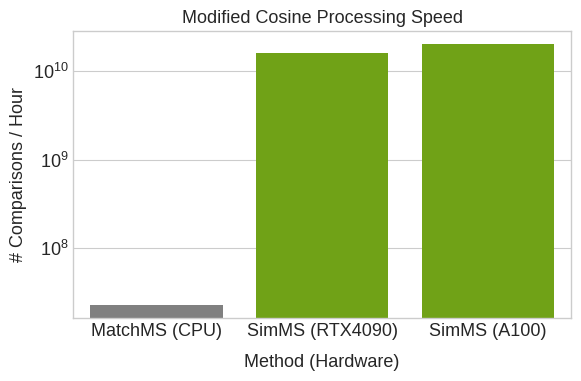

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression


goal_num = 100_000 * 1_500_000

# Filter dataframe for "ModifiedCosine" approaches
modified_cosine_df = df[df["kernel"].str.contains("ModifiedCosine")]

# Dictionary to store throughput at goal_num
performance_at_goal = []

# Estimate throughput for each approach at goal_num
for (kernel, label), data in modified_cosine_df.groupby(["kernel", "label"]):
    estimate_runtime = LinearRegression()
    estimate_runtime.fit(np.array(data[["pairs"]]), np.array(data[["time"]]))
    estimated_time_hr = estimate_runtime.predict([[goal_num]]).item() / 3600
    throughput = goal_num / estimated_time_hr
    performance_at_goal.append(
        {"kernel": kernel, "label": label, "throughput": throughput}
    )

# Convert to DataFrame
performance_df = pd.DataFrame(performance_at_goal)
performance_df = performance_df.sort_values("throughput")
# Set colors for CUDA and non-CUDA approaches
colors = [
    "gray" if "Cuda" not in kernel else "#76B900" for kernel in performance_df["kernel"]
]

# Organize x-axis labels
x_labels = ["MatchMS (CPU)", "SimMS (RTX4090)", "SimMS (A100)"]

# Plotting
plt.figure(figsize=(6, 4))
sns.barplot(
    data=performance_df,
    x="label",
    y="throughput",
    hue="kernel",
    dodge=False,
    palette=colors,
    legend=None,
)

plt.yscale("log")
plt.xlabel("Method (Hardware)", labelpad=10)
plt.ylabel("# Comparisons / Hour")
plt.title("Modified Cosine Processing Speed")
plt.grid(True, axis="y")
plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels)
# plt.legend(title="Kernel", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.legend(False)
plt.tight_layout()

plt.savefig("assets/perf_speedup.svg", bbox_inches="tight", dpi=200)
plt.show()